## Libraries and Links

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
url_financials = [
    'https://www.marketwatch.com/investing/stock/{}/financials?countrycode=vn',
    'https://www.marketwatch.com/investing/stock/{}/financials/balance-sheet?countrycode=vn',
    'https://www.marketwatch.com/investing/stock/{}/financials/cash-flow?countrycode=vn']
url_profile = 'https://www.marketwatch.com/investing/stock/{}/company-profile?countrycode=vn&mod=mw_quote_tab'
url_history = 'https://www.marketwatch.com/investing/stock/{}/download-data?startDate=01/01/2007&endDate=03/30/2023&countryCode=vn'

In [3]:
stock = 'VNM'

## Company Financials

In [4]:
# Function to convert strings (T (= trillion), B (= billion), M (= million), K (= thousand),...)  to float

def convert_to_float(value):
    change = str.maketrans({'T': '', 'B': '', 'M': '', 'K': '', ',':'', '%':'', '(': '-', ')':''})
    if 'T' in value:
        return float(value.translate(change))*10**12
    elif 'B' in value:
        return float(value.translate(change))*10**9
    elif 'M' in value:
        return float(value.translate(change))*10**6
    elif 'K' in value:
        return float(value.translate(change))*10**3
    elif '%' in value:
        return float(value.translate(change))/100
    elif value == '-':
        return np.nan
    elif value == 'N/A':
        return np.nan
    elif 'Stock Split' in value:
        return value.translate(change)
    else:
        return float(value.translate(change))

In [5]:
# Scrape Company Financials
  
def financial(stock):
    financials = {}
    for url in url_financials:
        responseF = requests.get(url.format(stock))
        soupF = BeautifulSoup(responseF.content, 'html.parser')
        title = soupF.find('li', {'class':'tab__item is-selected'}).find('a', {'class':'link js-subTab'}).text.strip()
        financials_content = soupF.find_all('div', {'class' : 'element__body fixed-column'})
        result = []
        for each in financials_content:
            financials_content_text = each.text
            lineF = financials_content_text.split('\n')
            while "" in lineF:
                lineF.remove('')
            data = []
            for i in range(0, len(lineF), 8):
                row = [lineF[i], lineF[i+3], lineF[i+4], lineF[i+5], lineF[i+6], lineF[i+2]]
                data.append(row)
                df = pd.DataFrame(data[1:], columns = data[0]).set_index('Item')
            result.append(df)
        financials[title] = result
    for key,part in financials.items():
        for sub in part:
            for col in sub.columns:
                sub[col] = sub[col].apply(convert_to_float)
        financials[key] = part
    return(financials)
financial(stock)

{'Income Statement': [                                                   2018          2019  \
  Item                                                                    
  Sales/Revenue                              5.256000e+13  5.632000e+13   
  Sales Growth                              -1.233000e-01  7.150000e-02   
  Cost of Goods Sold (COGS) incl. D&A        2.798000e+13  2.994000e+13   
  COGS Growth                               -2.322000e-01  7.000000e-02   
  COGS excluding D&A                         2.636000e+13  2.800000e+13   
  Depreciation & Amortization Expense        1.620000e+12  1.940000e+12   
  Depreciation                                        NaN           NaN   
  Amortization of Intangibles                         NaN           NaN   
  Gross Income                               2.458000e+13  2.638000e+13   
  Gross Income Growth                        4.540000e-02  7.310000e-02   
  Gross Profit Margin                                 NaN           NaN   
  SG&

In [6]:
# Shape, Info, Description

for key, value in financial(stock).items():
    print(f"DataFrame '{key}':")
    for i, df in enumerate(value):
        print(f"DataFrame {i+1}:")
        print(f"Shape: {df.shape}")
        print(f"Info: {df.info()}")
        print(f"Description:\n{df.describe()}\n")

DataFrame 'Income Statement':
DataFrame 1:
Shape: (57, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, Sales/Revenue to EBITDA Margin
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2018    38 non-null     float64
 1   2019    38 non-null     float64
 2   2020    40 non-null     float64
 3   2021    44 non-null     float64
 4   2022    19 non-null     float64
dtypes: float64(5)
memory usage: 2.7+ KB
Info: None
Description:
               2018          2019          2020          2021          2022
count  3.800000e+01  3.800000e+01  4.000000e+01  4.400000e+01  1.900000e+01
mean   5.923762e+12  6.324353e+12  6.668741e+12  6.065053e+12  9.884733e+12
std    1.105652e+13  1.181985e+13  1.229813e+13  1.213679e+13  1.544129e+13
min   -1.010000e+12 -1.040000e+12 -1.130000e+12 -1.090000e+12 -9.246300e+11
25%    1.648750e-01  7.037500e-02  5.830000e-02 -2.492500e-02  3.182000e+10
50%    6.127500e+10  3.526000e+10  1.02685

# Piostroski F-score

In [7]:
# Positive net income (1 point)

def net_income(stock, year):
    return financial(stock)['Income Statement'][0].loc['Net Income', year]
    
net_income(stock, '2022')

7590000000000.0

In [8]:
# Positive return on assets (ROA) in the current year (1 point)

def roa(stock, year):
    bl_asset = financial(stock)['Balance Sheet'][0]
    cur_asset = bl_asset.loc['Total Assets', year]
    prev_asset = bl_asset.loc['Total Assets', str(int(year)-1)]
    avg_asset = (cur_asset + prev_asset)/2
    return net_income(stock, year)/(avg_asset)

roa(stock, '2022')

0.1489257333464142

In [9]:
# Positive operating cash flow in the current year (1 point)

def ocf(stock, year):
    return financial(stock)['Cash Flow'][0].loc['Net Operating Cash Flow', year]
   
ocf(stock, '2022')

10030000000000.0

In [10]:
# Lower amount of long term debt in the current period, compared to the previous year (decreased leverage) (1 point)

def ltdebt(stock, year):
    bs_liabilities = financial(stock)['Balance Sheet'][1]
    cur_debt = bs_liabilities.loc['Long-Term Debt', year]
    prev_debt = bs_liabilities.loc['Long-Term Debt', str(int(year)-1)]
    return prev_debt - cur_debt

ltdebt(stock, '2022')


9610000000.0

In [11]:
# Higher current ratio this year compared to the previous year (more liquidity) (1 point)

def current_ratio(stock, year):
    bs_a = financial(stock)['Balance Sheet'][0]
    bs_l = financial(stock)['Balance Sheet'][1]

    cur_TCA = bs_a.loc['Total Current Assets', year]
    prev_TCA = bs_a.loc['Total Current Assets', str(int(year)-1)]
    cur_TCL = bs_l.loc['Total Current Liabilities', year]
    prev_TCL = bs_l.loc['Total Current Liabilities', str(int(year)-1)]

    current_ratio = cur_TCA/cur_TCL
    prev_ratio = prev_TCA/prev_TCL
    
    return current_ratio - prev_ratio

current_ratio(stock, '2022')

-0.054009367812331455

In [12]:
# No new shares were issued in the last year (lack of dilution) (1 point)

def new_share(stock, year):
    i_s = financial(stock)['Income Statement'][0]
    cur_outstandingshares = i_s.loc['Diluted Shares Outstanding', year]
    prev_outstandingshares = i_s.loc['Diluted Shares Outstanding', str(int(year)-1)]
    return cur_outstandingshares - prev_outstandingshares

new_share(stock, '2022')



0.0

In [13]:
# A higher gross margin compared to the previous year (1 point)

def gross_margin(stock, year):
    i_s = financial(stock)['Income Statement'][0]
    cur_grossmargin = i_s.loc['Gross Income', year] / i_s.loc['Sales/Revenue', year] 
    prev_grossmargin = i_s.loc['Gross Income', str(int(year)-1)] / i_s.loc['Sales/Revenue', str(int(year)-1)] 
    return cur_grossmargin - prev_grossmargin
gross_margin(stock, '2022')

-0.03272207735776578

In [14]:
# A higher asset turnover ratio compared to the previous year (1 point)

def asset_turnover_ratio(stock, year):
    i_s = financial(stock)['Income Statement'][0]
    bs_a = financial(stock)['Balance Sheet'][0]
    cur_revenue = i_s.loc['Sales/Revenue', year]
    prev_revenue = i_s.loc['Sales/Revenue', str(int(year)-1)]
    cur_assets = bs_a.loc['Total Assets', year]
    prev_assets1 = bs_a.loc['Total Assets', str(int(year)-1)]
    prev_assets2 = bs_a.loc['Total Assets', str(int(year)-2)]
    cur_avg_assets = (cur_assets + prev_assets1)/2
    prev_avg_assets = (prev_assets1 + prev_assets2)/2
    cur_atr = cur_revenue/cur_avg_assets
    prev_atr = prev_revenue/prev_avg_assets
    return cur_atr - prev_atr

asset_turnover_ratio(stock, '2022')

-0.019540489057894295

In [15]:
# Function to calculate Piotroski F-score

def piotroski_score(stock, year):
    pscore = 0
    if net_income(stock, year)>0:
        pscore+=1
    if roa(stock, year)>0:
        pscore+=1
    if ocf(stock, year)>0:
        pscore+=1
    if ocf(stock, year)>net_income(stock, year):
        pscore+=1
    if ltdebt(stock, year)>0:
        pscore+=1
    if current_ratio(stock, year)>0:
        pscore+=1
    if new_share(stock, year)<=0:
        pscore+=1
    if gross_margin(stock, year)>0:
        pscore+=1
    if asset_turnover_ratio(stock, year)>0:
        pscore+=1
    return pscore
piotroski_score(stock, '2022')  

6

In [16]:
# Define the years to include in the table
years = ['2020', '2021', '2022']

# Create an empty DataFrame to store the Piotroski scores
scores_df = pd.DataFrame(columns=['Year', 'Net Income', 'ROA', 'OCF', 'OCF > Net Income', 'LT Debt', 'Current Ratio', 'New Shares', 'Gross Margin', 'Asset Turnover Ratio', 'Piotroski Score'])

# Loop through each year, and calculate the Piotroski scores
for year in years:
    net_income_score = net_income(stock, year)
    roa_score = roa(stock, year)
    ocf_score = ocf(stock, year)
    ocf_vs_netincome = ocf(stock, year) - net_income(stock, year)
    lt_debt_score = ltdebt(stock, year)
    current_ratio_score = current_ratio(stock, year)
    new_share_score = new_share(stock, year)
    gross_margin_score = gross_margin(stock, year)
    atr_score = asset_turnover_ratio(stock, year)
    pscore = piotroski_score(stock, year)
    
    new_df = pd.DataFrame({'Year': year,
                          'Net Income': net_income_score,
                          'ROA': roa_score,
                          'OCF': ocf_score,
                           'OCF > Net Income': ocf_vs_netincome,
                          'LT Debt': lt_debt_score,
                          'Current Ratio': current_ratio_score,
                          'New Shares': new_share_score,
                          'Gross Margin': gross_margin_score,
                          'Asset Turnover Ratio': atr_score,
                          'Piotroski Score': pscore}, 
                                index = [0])
    # Add the Piotroski scores to the DataFrame
    scores_df = pd.concat([scores_df, new_df],ignore_index=True)
   
scores_transposed = scores_df.set_index('Year').T
rows = ~(scores_transposed.index.isin(['New Shares', 'Piotroski Score']))

# Convert the scores to binary values (0 or 1)
scores_transposed.loc[rows] = scores_transposed.loc[rows].applymap(lambda x: 1 if x > 0 else 0)

# Modify the "New Share" metric to only award a point if there are no new shares issued
scores_transposed.loc['New Shares'] = scores_transposed.loc['New Shares'].apply(lambda x: 1 if x <= 0 else 0)

scores_transposed


Year,2020,2021,2022
Net Income,1,1,1
ROA,1,1,1
OCF,1,1,1
OCF > Net Income,1,1,1
LT Debt,0,1,1
Current Ratio,1,1,0
New Shares,1,1,1
Gross Margin,0,0,0
Asset Turnover Ratio,0,0,0
Piotroski Score,6,7,6


## Company Profile

In [17]:
# Scrape Company Profile

def company_profile(stock):
    companyprofile = {}
    responseCP = requests.get(url_profile.format(stock))
    soupCP = BeautifulSoup(responseCP.content, 'html.parser')
    CP_content = soupCP.find_all("div", {'class': 'element element--table'})[0:5]
    for CP in CP_content:
        CP_content_part = CP.text
        lineCP = [x.strip() for x in CP_content_part.split('\n') if x.strip()]
        titleCP = lineCP[0]
        dataCP = []
        for i in range(1, len(lineCP) - 1,2):
            row = [lineCP[i], lineCP[i+1]]
            dataCP.append(row)
        contentCP = pd.DataFrame(dataCP, columns=['Item', 'Value']).set_index('Item')
        # contentCP = contentCP.set_index(contentCP.columns[0])
        companyprofile[titleCP] = contentCP
    for key,part in companyprofile.items():
        for col in part.columns:
            part[col] = part[col].apply(convert_to_float)
        companyprofile[key] = part
    return companyprofile

company_profile(stock)

{'VALUATION':                                      Value
 Item                                      
 P/E Current                          18.94
 P/E Ratio (w/ extraordinary items)   18.94
 P/E Ratio (w/o extraordinary items)  20.95
 Price to Sales Ratio                  2.65
 Price to Book Ratio                   5.33
 Price to Cash Flow Ratio             15.86
 Enterprise Value to EBITDA           10.90
 Enterprise Value to Sales             2.15
 Total Debt to Enterprise Value         NaN,
 'EFFICIENCY':                       Value
 Item                       
 Revenue/Employee        NaN
 Income Per Employeee    NaN
 Receivables Turnover    NaN
 Total Asset Turnover   1.18,
 'LIQUIDITY':                Value
 Item                
 Current Ratio   2.06
 Quick Ratio     1.70
 Cash Ratio      1.29,
 'PROFITABILITY':                              Value
 Item                              
 Gross Margin                0.3922
 Operating Margin            0.1627
 Pretax Margin              

In [18]:
# Shape, Info, Description

for key, value in company_profile(stock).items():
    print(f"DataFrame '{key}':")
    print(f"Shape: {value.shape}")
    print(f"Info: {value.info()}")
    print(f"Description:\n{value.describe()}\n")

DataFrame 'VALUATION':
Shape: (9, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, P/E Current to Total Debt to Enterprise Value
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   8 non-null      float64
dtypes: float64(1)
memory usage: 144.0+ bytes
Info: None
Description:
          Value
count   8.00000
mean   11.96500
std     7.75945
min     2.15000
25%     4.66000
50%    13.38000
75%    18.94000
max    20.95000

DataFrame 'EFFICIENCY':
Shape: (4, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Revenue/Employee to Total Asset Turnover
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1 non-null      float64
dtypes: float64(1)
memory usage: 64.0+ bytes
Info: None
Description:
       Value
count   1.00
mean    1.18
std      NaN
min     1.18
25%     1.18
50%     1.18
75%     1.18
max     1.18

DataFrame 'LIQUIDITY':
Shape: (3, 1)
<

## Historical data

### Web scraping and Data cleaning

In [19]:
# Historical Stock data link

url1 = 'https://www.marketwatch.com/investing/stock/{}/downloaddatapartial?partial=true&index='
url2 = '&countryCode=vn&iso=&startDate={}%2000%3A00%3A00&endDate={}%2000%3A00%3A00&frequency={}&downloadPartial=true&csvDownload=false&newDates=false'

stock = 'VNM'
start = '01%2F01%2F2007'
end = '03%2F30%2F2023'
freq = 'P1D'

In [20]:
#Scrape Historical Stock data

def historical_data(stock, start, end, freq):
    historical = []
    page_number = 0
    while True:
        responseHD = requests.get(url1.format(stock) + str(page_number) + url2.format(start, end, freq))
        soupHD = BeautifulSoup(responseHD.text, 'html.parser')
        HD_content = soupHD.find('tbody', {'class':'table__body row-hover'}).find_all('tr', {'class':'table__row'})
        for each in HD_content:
            HD_content = each.text
            lineHD = [x.strip() for x in HD_content.split('\n') if x.strip()]
            historical.append(lineHD[1:])
        next_button = soupHD.find('a', {'class': 'link align--right j-next', 'data-is-disabled': 'false'})
        if not next_button:
            break
        page_number += 1
    
    historicaldata = pd.DataFrame(historical, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    return historicaldata

In [21]:
hd = historical_data(stock, start, end, freq)
hd.head()

,Date,Open,High,Low,Close,Volume
0,03/30/2023,"₫74,700","₫75,400","₫74,600","₫75,000","838,700"
1,03/29/2023,"₫74,700","₫74,900","₫74,400","₫74,900","907,400"
2,03/28/2023,"₫74,500","₫75,300","₫74,400","₫74,400","1,650,000"
3,03/27/2023,"₫75,000","₫75,000","₫74,300","₫74,600","1,461,500"
4,03/24/2023,"₫75,000","₫75,500","₫74,800","₫75,000","932,300"


In [22]:
#Shape, Info

hd.shape
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3881 non-null   object
 1   Open    3881 non-null   object
 2   High    3873 non-null   object
 3   Low     3873 non-null   object
 4   Close   3873 non-null   object
 5   Volume  3873 non-null   object
dtypes: object(6)
memory usage: 182.1+ KB


In [23]:
# Check for null values

hd_null = hd[hd['High'].isna()]
hd_nonnull = hd.dropna().iloc[::-1]
hd_null.head()
hd_nonnull.head()

,Date,Open,High,Low,Close,Volume
3880,09/12/2007,"₫14,378","₫14,378","₫14,378","₫14,378","795,357"
3879,09/13/2007,"₫14,468","₫14,468","₫14,468","₫14,468","392,024"
3878,09/14/2007,"₫14,735","₫14,735","₫14,735","₫14,735","1,961,016"
3877,09/17/2007,"₫14,825","₫14,825","₫14,825","₫14,825","1,193,204"
3876,09/18/2007,"₫14,825","₫14,825","₫14,825","₫14,825","935,998"


In [24]:
# Remove null values, Convert to datettime and float

date_format = "%m/%d/%Y"
word = str.maketrans({'₫':'', ',':''})
hd_nonnull['Date'] = pd.to_datetime(hd_nonnull['Date'], format=date_format)
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns:
    hd_nonnull[col] = pd.to_numeric(hd_nonnull[col].str.translate(word), errors='coerce')

In [25]:
# Info, Description

hd_nonnull.info()
hd_nonnull.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3873 entries, 3880 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3873 non-null   datetime64[ns]
 1   Open    3873 non-null   int64         
 2   High    3873 non-null   int64         
 3   Low     3873 non-null   int64         
 4   Close   3873 non-null   int64         
 5   Volume  3873 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 211.8 KB


,Open,High,Low,Close,Volume
count,3873.000000,3873.000000,3873.000000,3873.000000,3.873000e+03
mean,61440.029951,62021.071779,60891.715466,61444.837852,1.642842e+06
std,38214.904737,38563.810526,37871.210048,38210.441757,2.031261e+06
min,5939.000000,6073.000000,5939.000000,6073.000000,2.016000e+03
25%,20540.000000,20540.000000,20362.000000,20540.000000,5.581810e+05
50%,57468.000000,58272.000000,57066.000000,57581.000000,1.200169e+06
75%,96528.000000,97333.000000,95667.000000,96333.000000,2.194058e+06
max,148958.000000,149305.000000,147986.000000,149167.000000,5.833350e+07


### Exploratory Data Analysis

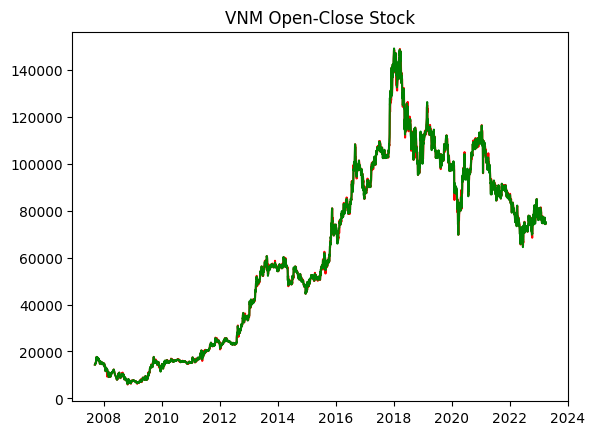

In [26]:
hd_nonnull = hd_nonnull.set_index('Date')
plt.plot(hd_nonnull.index,
         hd_nonnull['Open'],
         color='red',
         label='Open')
plt.plot(hd_nonnull.index,
         hd_nonnull['Close'],
         color='green',
         label='Close')
plt.title(stock+' Open-Close Stock')
plt.show()

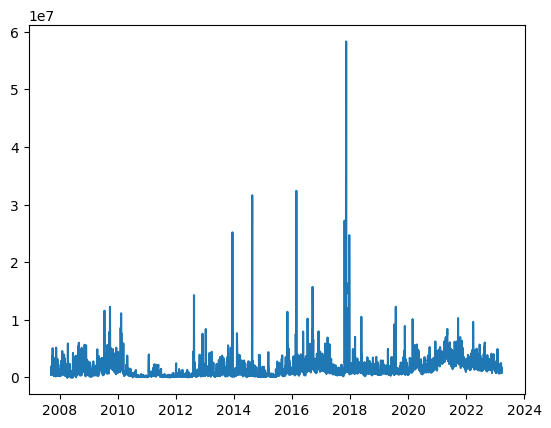

In [27]:
plt.plot(hd_nonnull.index,
         hd_nonnull['Volume'])
plt.show()

/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_952/2995016739.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)
/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_952/2995016739.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hd_nonnull[col])
/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_952/2995016739.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-l

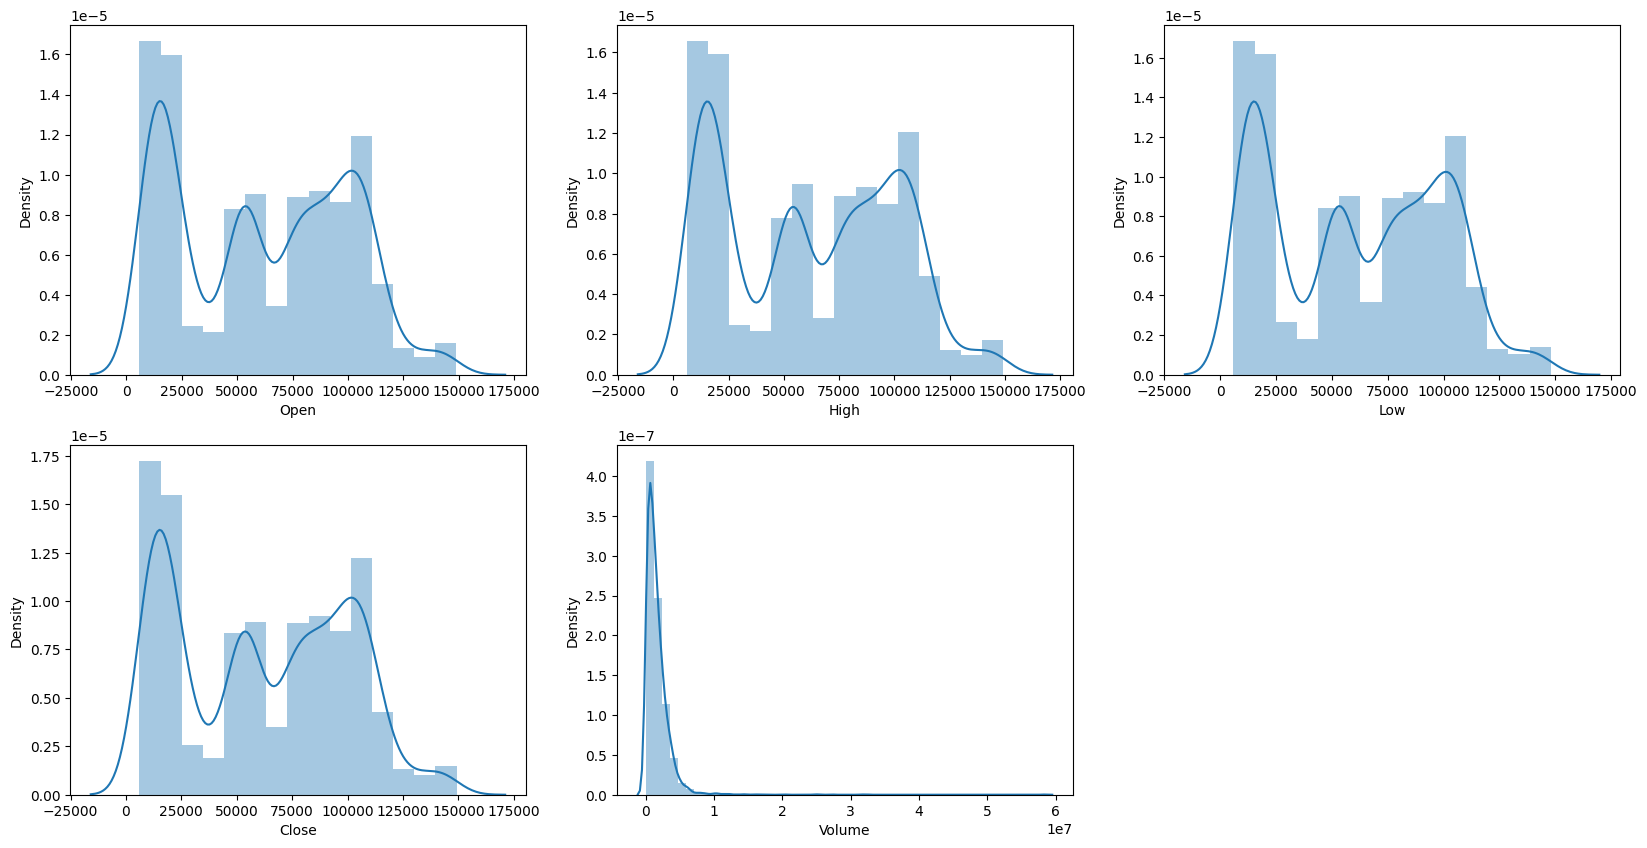

In [28]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(columns):
    plt.subplot(2,3,i+1)
    sns.distplot(hd_nonnull[col])
plt.show()

/var/folders/rx/dk6_2ggn6h15_19_9d9rwlw40000gn/T/ipykernel_952/334268350.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


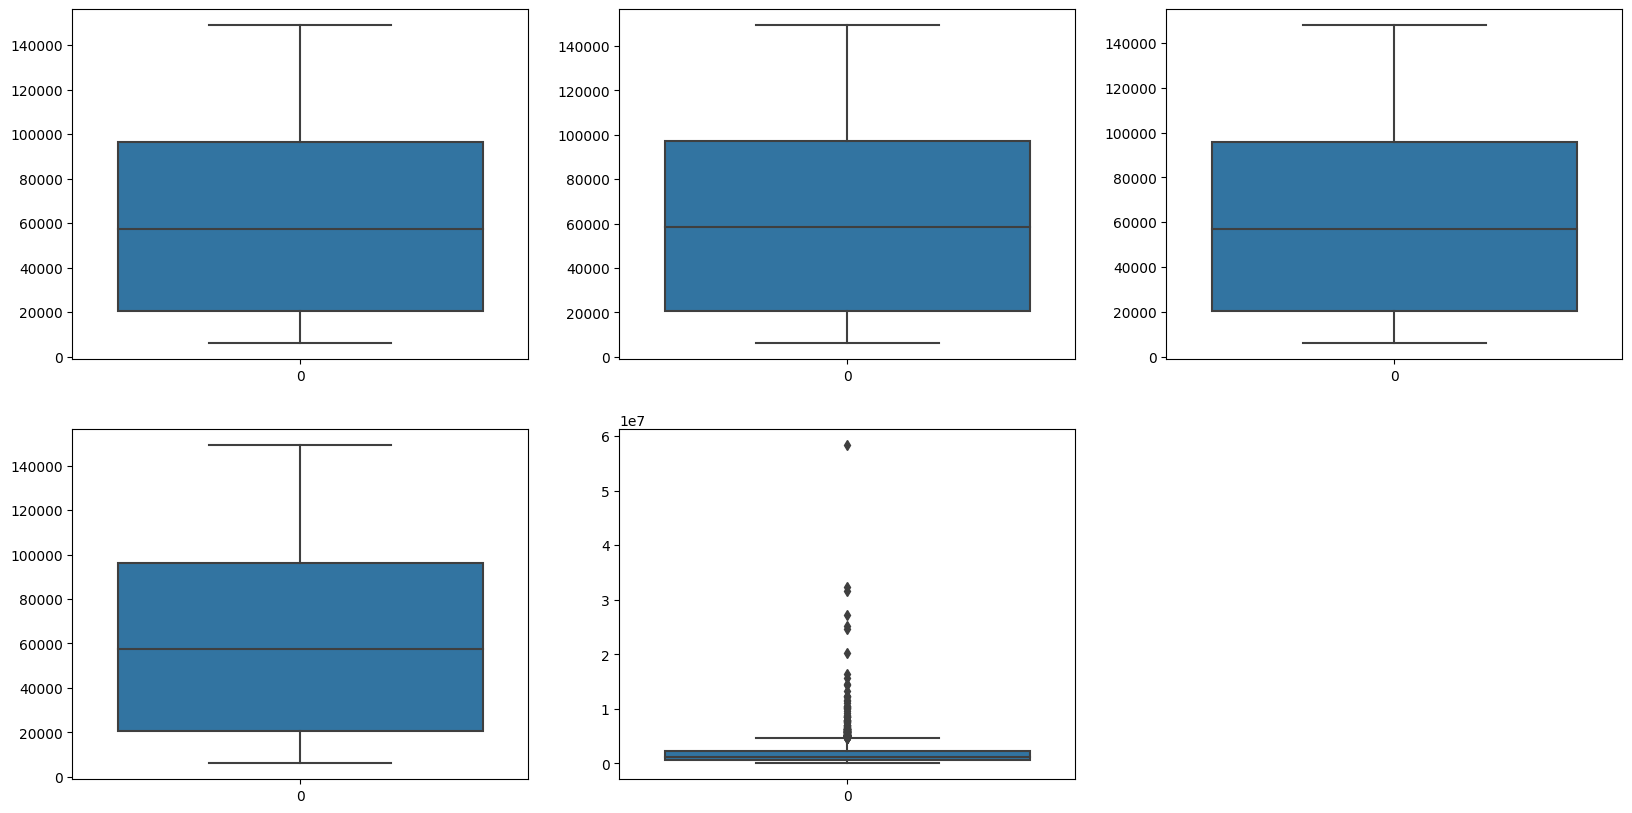

In [29]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(columns):
    plt.subplot(2,3,i+1)
    sns.boxplot(hd_nonnull[col])
plt.show()

### Setting up target for machine learning

In [30]:
# Create a column "Tomorrow" that takes the value of "Close" column on the next day => Today's tommorrow (prediction) == Tomorrow's close
hd_nonnull['Tomorrow'] = hd_nonnull['Close'].shift(-1)
hd_nonnull.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
2007-09-12,14378,14378,14378,14378,795357,14468.0
2007-09-13,14468,14468,14468,14468,392024,14735.0
2007-09-14,14735,14735,14735,14735,1961016,14825.0
2007-09-17,14825,14825,14825,14825,1193204,14825.0
2007-09-18,14825,14825,14825,14825,935998,14825.0


In [31]:
# Our target is to predict whether tomorrow price is higher than today price
hd_nonnull['Target'] = (hd_nonnull['Tomorrow'] > hd_nonnull['Close']).astype(int)

### Training initial machine learning model

In [32]:
 from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = hd_nonnull.iloc[:int((int(hd_nonnull.shape[0])*0.8))]
test = hd_nonnull.iloc[int((int(hd_nonnull.shape[0])*0.8)):]
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [33]:
# Measure how accurate the model is
from sklearn.metrics import precision_score
preds = pd.Series(model.predict(test[predictors]), index=test.index)

In [34]:
# Calculate precision score using actual targets and predicted targets
precision_score(test['Target'], preds)

0.46303501945525294

In [35]:
# Plot prediction
combined = pd.concat([test['Target'],preds], axis=1)

<Axes: xlabel='Date'>

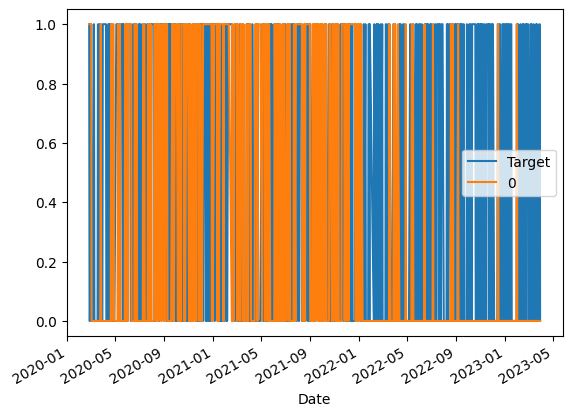

In [36]:
combined.plot()

### Build a backtesting system

In [37]:
def predict(train, test, predictors, model):
    #create a prediction function(same as all we did above)
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'],preds], axis=1)
    return combined

In [38]:
def backtest(data, model, predictors, start=2500, step=250):
    #250: approximatedly 1 year, 2500 = 10 years -> take first 10 years and predict 11th year, then take 11 yrs and predict 12th year,...
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predicted = predict(train, test, predictors, model)
        all_predictions.append(predicted)
    return pd.concat(all_predictions)

    

In [39]:
predictions = backtest(hd_nonnull, model, predictors)
predictions

,Target,Predictions
Date,,
2017-09-29,0,0
2017-10-02,0,0
2017-10-03,1,1
2017-10-04,1,0
2017-10-05,0,0
...,...,...
2023-03-24,0,0
2023-03-27,0,0
2023-03-28,1,0


In [40]:
predictions['Predictions'].value_counts()
    # We predict market go down on 993 days and go up in 380 days

0    993
1    380
Name: Predictions, dtype: int64

In [41]:
precision_score(predictions['Target'], predictions['Predictions'])

0.49473684210526314

In [42]:
predictions['Target'].value_counts()/predictions.shape[0]

0    0.549162
1    0.450838
Name: Target, dtype: float64

### Improving the model

In [43]:
# Add additional predictors to our model
horizons = [2, 5, 60, 250, 500]
# Calculate rolling mean close price in the last 2 days, last trading week (5 days), the last 3 months (60 trading days), last year, last 2 years
new_predictors = ["Close"]
for horizon in horizons:
    rolling_averages = hd_nonnull.rolling(horizon, min_periods=1).mean()
        
    ratio_column = f"Close_ration_{horizon}"
    hd_nonnull[ratio_column] = hd_nonnull['Close']/rolling_averages['Close']
    
    trend_column = f"Trend_{horizon}"
    hd_nonnull[trend_column] = hd_nonnull.shift(1).rolling(horizon, min_periods=1).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]


In [44]:
hd_nonnull = hd_nonnull.dropna(subset = hd_nonnull.columns[hd_nonnull.columns != 'Tomorrow'])

In [45]:
hd_nonnull.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_ration_2,Trend_2,Close_ration_5,Trend_5,Close_ration_60,Trend_60,Close_ration_250,Trend_250,Close_ration_500,Trend_500
Date,,,,,,,,,,,,,,,,,
2007-09-13,14468,14468,14468,14468,392024,14735.0,1,1.003120,1.0,1.003120,1.0,1.003120,1.0,1.003120,1.0,1.003120,1.0
2007-09-14,14735,14735,14735,14735,1961016,14825.0,1,1.009143,2.0,1.014318,2.0,1.014318,2.0,1.014318,2.0,1.014318,2.0
2007-09-17,14825,14825,14825,14825,1193204,14825.0,0,1.003045,2.0,1.015307,3.0,1.015307,3.0,1.015307,3.0,1.015307,3.0
2007-09-18,14825,14825,14825,14825,935998,14825.0,0,1.000000,1.0,1.012208,3.0,1.012208,3.0,1.012208,3.0,1.012208,3.0
2007-09-19,14825,14825,14825,14825,1149310,15003.0,1,1.000000,0.0,1.006067,3.0,1.010153,3.0,1.010153,3.0,1.010153,3.0


In [46]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [47]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'],preds], axis=1)
    return combined

In [48]:
predictions = backtest(hd_nonnull, model, new_predictors)

In [49]:
predictions['Predictions'].value_counts()

0.0    1244
1.0     128
Name: Predictions, dtype: int64

In [50]:
precision_score(predictions['Target'], predictions['Predictions'])

0.546875

## Visualization

In [51]:
# Import libraries

import panel as pn
pn.extension('tabulator')
import hvplot.pandas 

In [52]:
# Create stock price line chart

line_stock = (hd_nonnull['Close']/1000).hvplot.line(width=800, 
                                                    height=400, 
                                                    xlabel='Year', 
                                                    ylabel='Price (VND in thousands)', 
                                                    title='Stock Price',
                                                    color = '#9ecae1')
line_stock

:Curve   [Date]   (Close)

In [53]:
# Create Piotroski F-score table

table_Piotroski = scores_transposed.reset_index().hvplot.table(title = 'Piotroski F-Score')
table_Piotroski

:Table   [index,2020,2021,2022]

In [54]:
# Create Company Profile table

# Create the select widget
def update_chart(event):
    chart.value = company_profile(stock)[select.value]

# Create the select widget
select = pn.widgets.Select(name='Select', options=list(company_profile(stock).keys()))
select.param.watch(update_chart, 'value')

# Create the initial chart
chart = pn.widgets.Tabulator(company_profile(stock)[select.value])

# Combine the select widget and chart into a Panel layout
tables_CP = pn.Column('## Company Profile', select, chart)

# Display the layout
tables_CP


Column
    [0] Markdown(str)
    [1] Select(options=['VALUATION', ...], value='VALUATION')
    [2] Tabulator(value=              ...)

In [55]:
# Create Total Assets bar chart

assets = (financial(stock)['Balance Sheet'][0].loc[['Total Current Assets', 'Total Assets']].T)/(10**9)
assets['Total Long-term Assets'] = assets['Total Assets'] - assets['Total Current Assets']
# assets['Total Current Assets'] = assets['Total Current Assets']/(10**9)
assets_stacked = assets.hvplot.bar(
    y=['Total Current Assets', 'Total Long-term Assets'],
    stacked=True,
    title='Total Assets',
    xlabel='Year',
    ylabel='Amount (VND in billions)',
    color = ['#9ecae1', '#DC5039'],
)
assets_stacked
# assets

:Bars   [index,Item]   (value)

In [56]:
# Create Total Liabilities bar chart

liabilities = (financial(stock)['Balance Sheet'][1].loc[['Total Current Liabilities', 'Total Liabilities']].T)/(10**9)
liabilities['Total Long-term Liabilities'] = liabilities['Total Liabilities'] - liabilities['Total Current Liabilities']
# liabilities['Total Current Liabilities'] = liabilities['Total Current Liabilities']/(10**9)
liabilities_stacked = liabilities.hvplot.bar(
    y=['Total Current Liabilities', 'Total Long-term Liabilities'],
    stacked=True,
    title='Total Liabilities',
    xlabel='Year',
    ylabel='Amount (VND in billions)',
    color = ['#9ecae1', '#DC5039']
)
liabilities_stacked

:Bars   [index,Item]   (value)

In [57]:
# Create Total Equity bar chart

equity = (financial(stock)['Balance Sheet'][1].loc['Total Equity'].T)/(10**9)
equity_stacked = equity.hvplot.bar(
    stacked=True,
    title='Total Equity',
    xlabel='Year',
    ylabel='Amount (VND in billions)',
    color = ['#9ecae1']
)
equity_stacked

:Bars   [index]   (Total Equity)

In [58]:
# Create Revenue and Profit line chart

profit = (financial(stock)['Income Statement'][0].loc[['Sales/Revenue','Gross Income','Net Income']].T)/(10**9)
profit_grouped = profit.hvplot.line(
    stacked=False,
    title='Revenue and Profit',
    xlabel='Year',
    ylabel='Amount (VND in billions)',
    # yaxis='left',
    color = ['#9ecae1', '#DC5039', '#35B778'],
    # rot=90
)
# profit_line = profit.hvplot.line(color = ['#9ecae1', '#DC5039', '#FCFEA4'])

profit_grouped 
# * profit_line


:NdOverlay   [Item]
   :Curve   [index]   (value)

In [59]:
# Create Net Cashflow bar chart

cashflow = (pd.concat([financial(stock)['Cash Flow'][0].loc[['Net Operating Cash Flow']].T, 
                       financial(stock)['Cash Flow'][1].loc[['Net Investing Cash Flow']].T, 
                       financial(stock)['Cash Flow'][2].loc[['Net Financing Cash Flow']].T], 
                      axis=1))/(10**9)
cashflow_stacked = cashflow.hvplot.bar(
    stacked=True,
    title='Net Cashflow',
    xlabel='Year',
    ylabel='Amount (VND in billions)',
    color = ['#9ecae1', '#DC5039', '#FCFEA4']
)

cashflow['Net Cashflow'] = cashflow['Net Operating Cash Flow'] + cashflow['Net Investing Cash Flow'] + cashflow['Net Financing Cash Flow']
cashflow_line = cashflow.hvplot.line(y = 'Net Cashflow', color = '#35B778')
net_cashflow = cashflow_stacked * cashflow_line 
net_cashflow

:Overlay
   .Bars.I  :Bars   [index,Item]   (value)
   .Curve.I :Curve   [index]   (Net Cashflow)

In [60]:
# Create Profit Margin line chart

i_s = financial(stock)['Income Statement'][0]
grosspm = i_s.loc['Gross Income']/i_s.loc['Sales/Revenue']
grosspm.name = 'Gross Profit Margin'
netpm = i_s.loc['Net Income']/i_s.loc['Sales/Revenue']
netpm.name = 'Net Profit Margin'
profitmargin = pd.concat([grosspm, netpm], axis=1)*100
profitmargin
profitmargin_line = profitmargin.hvplot.line(
    title = 'Profit Margin',
    xlabel='Year',
    ylabel='Profit Margin (%)',
    # yaxis='left',
    color = ['#9ecae1', '#DC5039'])
profitmargin_line
    

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### Creating Dashboard

In [61]:
# Layout using Template

template = pn.template.FastListTemplate(
    title="Vinamilk Financial Dashboard",
    sidebar=[pn.pane.Markdown("# Vinamilk Financial Dashboard"), 
             pn.pane.Markdown("#### Vietnam Dairy Products (Vinamilk) is the largest diary company in Vietnam. Its products range from fresh milk, yoghurt, ice-cream to cheese, milk powder, fruit juice, smoothie and tea. Vinamilk distributes its products in Australia, Cambodia, Philippines, and the United States. The company was founded August 20, 1976 and is headquartered in Ho Chi Minh City, Vietnam."),
             pn.pane.PNG('Logo_vinamilk.png', sizing_mode = 'scale_both')],
    main=[pn.Row(pn.Column(tables_CP),
                 pn.Column(table_Piotroski),
                 pn.Column(line_stock)),
          pn.Row(pn.Column(profit_grouped),
                 pn.Column(profitmargin_line),
                 pn.Column(net_cashflow)),
          pn.Row(pn.Column(assets_stacked),
                 pn.Column(liabilities_stacked),
                 pn.Column(equity_stacked))],
    accent_base_color = "#88d8b0",
    header_background = "#88d8b0",
)
template.show();

Launching server at http://localhost:50058


# End